# SHAP Visualization

## Loading Data

In [1]:
import torch
from torch import nn
from torch.utils import data
from torchvision import transforms, datasets, models
import shap

import matplotlib.pyplot as plt
import numpy as np
import math

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
train_root_dir= "path to root directory" # example: "../../Project/GastroVision22/train"
val_root_dir= "path to validation directory" # example: "../../Project/GastroVision22/val"
test_root_dir= "path to test directory" # example: "../../Project/GastroVision22/test"
model_path = "path to best mode" # example: "./C_22_32.pth"

In [3]:
n_classes=22  # number of classes used for training
batch_size=32

In [4]:
####################################
# Training
####################################

trans={    
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
    ]),
}

In [5]:
###########################
# Checking if GPU is used
###########################

use_cuda=torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
device=torch.device("cuda:0" if use_cuda else "mps" if use_mps else "cpu")
device

'cpu'

In [6]:
#Initialize model
print('Best model path:{}'.format(model_path))
denseNet_model= models.densenet121(weights=False).to(device)

n_inputs = denseNet_model.classifier.in_features
denseNet_model.classifier = nn.Sequential(
              nn.Linear(n_inputs, n_classes),               
              nn.LogSoftmax(dim=1))

checkpoint=torch.load(model_path,map_location=device)   # loading best model
denseNet_model.load_state_dict(checkpoint['model_state_dict'])
denseNet_model.to(device)

Best model path:./C_22_32.pth


Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
#Test Data Generator
test_dataset= datasets.ImageFolder(test_root_dir,transform=trans['test'])
test_generator=data.DataLoader(test_dataset,batch_size, shuffle=True)
print('Number of Test set images:{}'.format(len(test_dataset)))

Number of Test set images:1586


In [8]:
class_names = test_dataset.classes
print("Total Classes: ", len(class_names))
print(class_names)

Total Classes:  22
['Accessory tools', "Barrett's esophagus", 'Blood in lumen', 'Cecum', 'Colon diverticula', 'Colon polyps', 'Colorectal cancer', 'Duodenal bulb', 'Dyed-lifted-polyps', 'Dyed-resection-margins', 'Esophagitis', 'Gastric polyps', 'Gastroesophageal_junction_normal z-line', 'Ileocecal valve', 'Mucosal inflammation large bowel', 'Normal esophagus', 'Normal mucosa and vascular pattern in the large bowel', 'Normal stomach', 'Pylorus', 'Resected polyps', 'Retroflex rectum', 'Small bowel_terminal ileum']


## Implementing SHAP

In [98]:
batch = next(iter(test_generator))
images, labels = batch

tensor_images = torch.stack(list(unique_instances.values()))
tensor_labels = torch.stack(list(unique_instances.keys()))

background = tensor_images[:2]
test_images = tensor_images[2:5]
test_labels = tensor_labels[2:5]

In [99]:
explainer = shap.DeepExplainer(denseNet_model, background.to(device))
shap_values, indexes = explainer.shap_values(test_images.to(device), ranked_outputs=3)

In [100]:
# plotting_instances = 3

# shap_values = shap_values_explainer
# print("Taking only {} predictions to explain: ".format(len(shap_values)))

In [101]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

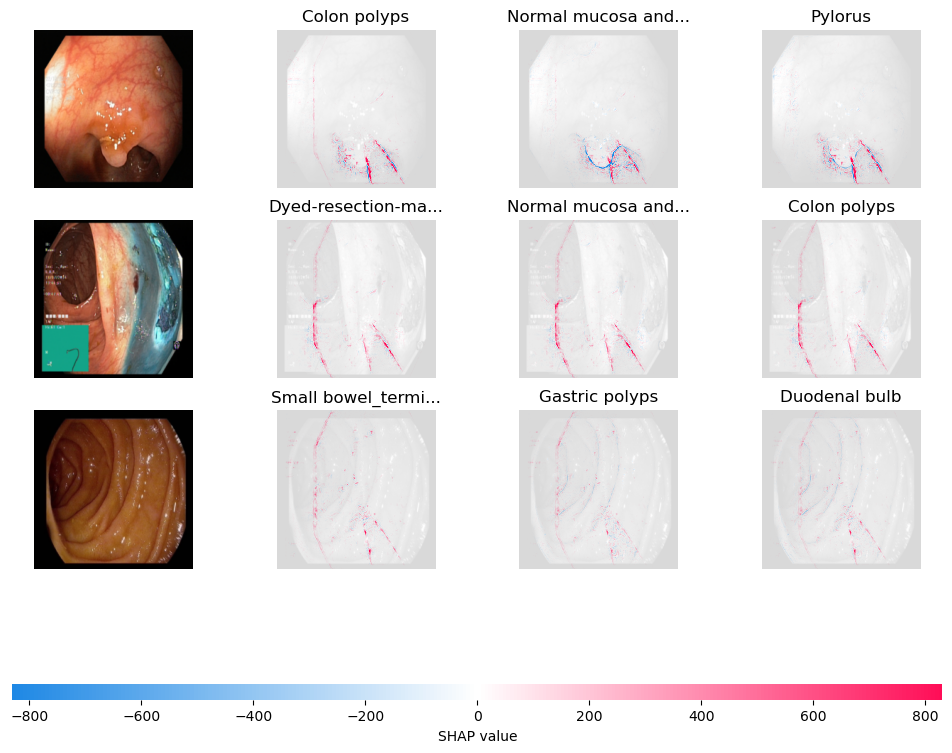

In [102]:
# get the names for the classes
index_names = np.vectorize(lambda x: truncate_title(class_names[x], 20))(indexes)
shap.image_plot(shap_numpy, test_numpy, index_names)